In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
train_data=pd.read_csv(r'C:\Users\sanja\Downloads\train_data.csv\train_data.csv')
test_data=pd.read_csv(r'C:\Users\sanja\Downloads\test_data.csv')
train_data.shape


(12379, 31)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV,ShuffleSplit,RandomizedSearchCV
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,MaxAbsScaler,LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.feature_selection import RFE,mutual_info_regression,SelectKBest
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report



In [18]:
(rows,cols)=train_data.shape
rows,cols

(12379, 31)

**Data analysis**

In [19]:
data_anl=train_data.copy()
col=data_anl.columns


Data separator functions

In [20]:
def num_filter(data):

  num_idx=data.columns.get_indexer(data.select_dtypes(['int64','float64']).columns)
  return data[col[num_idx]]

def cat_filter(data):
  #separating label and encoding 
  Y=LabelEncoder().fit_transform(data['Offer Accepted'])
  #droping columns : label
  df=data.drop(['Offer Accepted'],axis=1)
  cat_idx = df.columns.get_indexer(df.select_dtypes('object').columns)
  col=df.columns
  return df[col[cat_idx]]


#Boxplot for numerical data which has continuous values
def box_plot(data):
  num=num_filter(data)
  for x in num.columns:
    if(len(num[x].value_counts())>2):
      print(sns.boxplot(data=num[x],orient='h'))



Missing values Detection


In [21]:
missing_count=data_anl.isnull().sum()
for x,y in zip(missing_count,col):
  ratio=x/data_anl.shape[0]
  if(ratio>0.4):
    print(y,ratio)
#Result : Feature "Car" is having more missing values. Therefore dropping it  



car 0.9910332013894498



Features with 0 Variance

In [22]:
for x in col:
  if(len(data_anl[x].value_counts())==1):
    print(x)
#Result : Feature "Travelled More that 5 mins" are having same value everywhere

travelled_more_than_5mins_for_offer


Outliers Detection

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


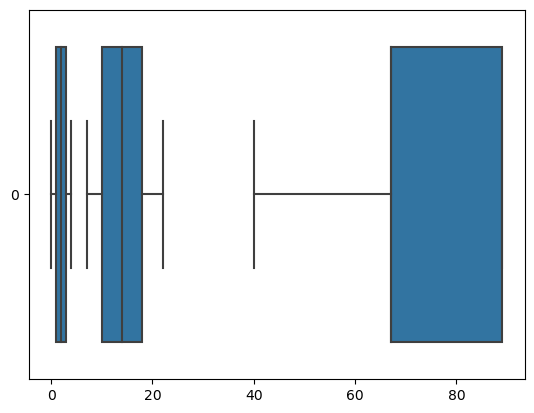

In [23]:
box_plot(data_anl)
#Result : No outliers        


Scale analysis

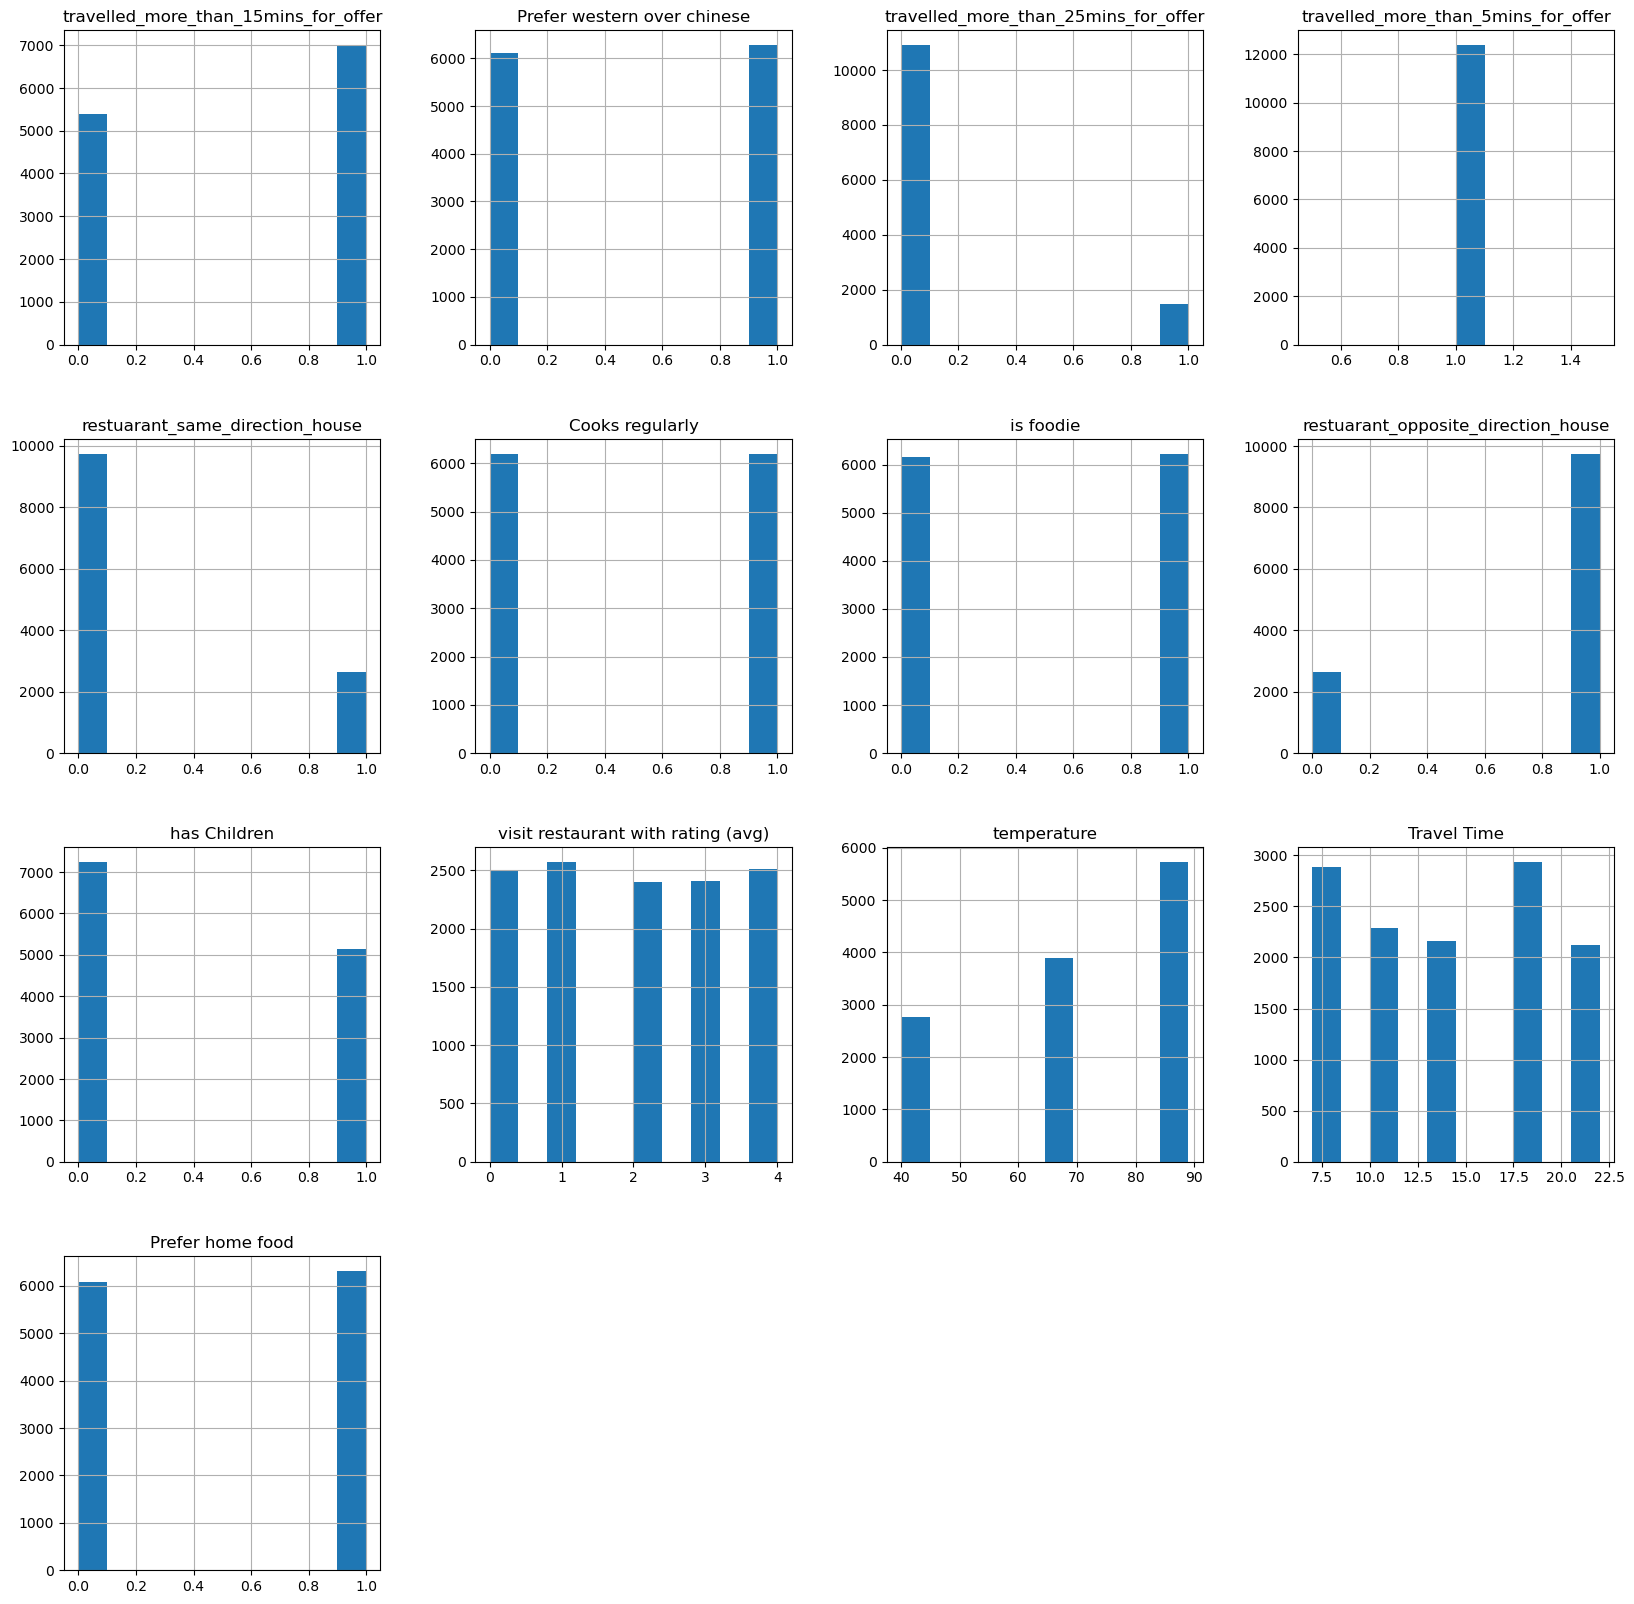

In [24]:
num_data=num_filter(data_anl)
num_data.hist(figsize=(20,20))
plt.show()
#Result : numerical features are on different scales - Use a scaler

 Results : 
*  Features 'car','travelled More that 5 mins' shoulde be deleted
*  Features should be scaled

**Data Preprocessing**

In [25]:
data=train_data.copy()
col=data.columns

In [26]:


def label_preprocessor(data):
  est_label=[('imputer',SimpleImputer(strategy='most_frequent'))]
  label_pipe=Pipeline(steps=est_label)
  label_transform=ColumnTransformer(transformers=[('label_pipe',label_pipe,['Offer Accepted'])])
  return LabelEncoder().fit_transform(label_transform.fit_transform(data).ravel())




def preprocessor(data):

  df=data.drop(['travelled_more_than_5mins_for_offer','car'],axis=1)
  train=False
  try:
    #separating label and encoding 
    Y=label_preprocessor(df)

    #droping columns : with more missing value (car), constant everywhere (travelled more than 5 mins) and label
    df=df.drop(['Offer Accepted'],axis=1)
    print('Processing Train data')
    train=True
  except:
    print('Processing test data')  

  cat_idx = df.columns.get_indexer(df.select_dtypes('object').columns)
  cat_est=[('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(sparse=False))]
  cat_pipe=Pipeline(steps=cat_est)

  num_idx=df.columns.get_indexer(df.select_dtypes(['int64','float64']).columns)
  num_est=[('imputer',SimpleImputer(strategy='most_frequent')),('scaler',MinMaxScaler())]       
  num_pipe=Pipeline(steps=num_est)  

  transform=ColumnTransformer(transformers=[('num_process',num_pipe,num_idx),('cat_process',cat_pipe,cat_idx)])
  features=transform.fit_transform(df)
  if(train):
    return features,Y
  else:
    return features  


  
  #transform=ColumnTransformer(transformers=[('num_process',num_preprocessor()),('cat_process',cat_preprocessor())])
  #return transform.fit_transform(df)



X,Y=preprocessor(data)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,stratify=Y)
x_train.shape

Processing Train data


C:\Users\sanja\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


(9903, 109)


Classificaton report function

In [27]:
def cls_report(est):
  y_pred=est.predict(x_test)
  print(classification_report(y_test,y_pred))
  return 


**Training**

Finding the best classifier

In [28]:
#Finding best estimator
train_score=[]
test_score=[]
est=[['Lr',LogisticRegression(max_iter=5000)],['SVC',SVC()],['KNN',KNeighborsClassifier()],['Dec_Tree',DecisionTreeClassifier()]]
for x in est:
    x[1].fit(x_train,y_train)
    train_score.append(x[1].score(x_train,y_train))
    test_score.append(x[1].score(x_test,y_test))
    print(x[0])
    print(cls_report(x[1]))

Lr
              precision    recall  f1-score   support

           0       0.57      0.43      0.49      1077
           1       0.63      0.75      0.68      1399

    accuracy                           0.61      2476
   macro avg       0.60      0.59      0.59      2476
weighted avg       0.60      0.61      0.60      2476

None
SVC
              precision    recall  f1-score   support

           0       0.62      0.44      0.52      1077
           1       0.65      0.79      0.71      1399

    accuracy                           0.64      2476
   macro avg       0.63      0.62      0.61      2476
weighted avg       0.64      0.64      0.63      2476

None


C:\Users\sanja\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sanja\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

KNN
              precision    recall  f1-score   support

           0       0.54      0.49      0.51      1077
           1       0.63      0.68      0.65      1399

    accuracy                           0.59      2476
   macro avg       0.59      0.58      0.58      2476
weighted avg       0.59      0.59      0.59      2476

None
Dec_Tree
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      1077
           1       0.62      0.62      0.62      1399

    accuracy                           0.57      2476
   macro avg       0.56      0.56      0.56      2476
weighted avg       0.57      0.57      0.57      2476

None


C:\Users\sanja\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


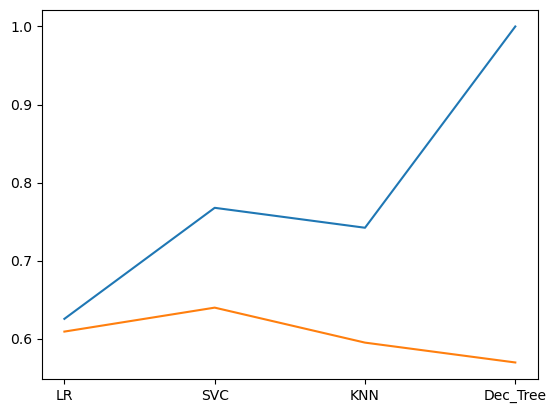

In [29]:
axis=['LR','SVC','KNN','Dec_Tree']
plt.plot(axis,train_score)
plt.plot(axis,test_score)
plt.show()

**Results**
*  Select support vector classifier
*  Select DecisionTreeClassifier

**DecisionTreeClassifier**

In [30]:
depths=[2,4,6,8,10,14,16,18]
train_score=[]
test_score=[]
for x in depths:
    clf=DecisionTreeClassifier(max_depth=x)
    clf.fit(x_train,y_train)
    train_score.append(clf.score(x_train,y_train))
    test_score.append(clf.score(x_test,y_test))   

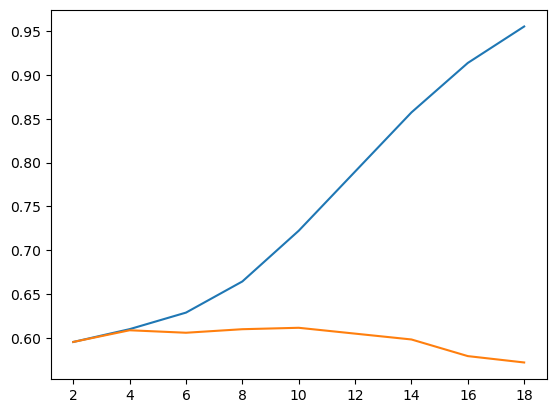

In [31]:
plt.plot(depths,train_score)
plt.plot(depths,test_score)
plt.show()

Result
* Best_depth = 10

In [32]:
dtc=DecisionTreeClassifier(max_depth=10)
dtc.fit(x_train,y_train)
print('DecicionTree test score : ',dtc.score(x_test,y_test))

DecicionTree test score :  0.614297253634895


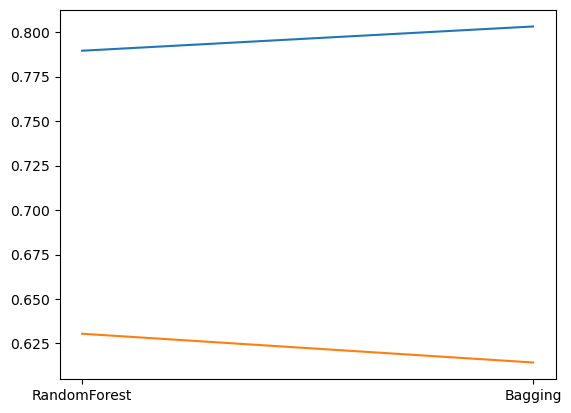

In [33]:
#Finding best estimator
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

train_loss=[]
test_loss=[]
est=[RandomForestClassifier(max_depth=10),BaggingClassifier(base_estimator=dtc)]
names=['RandomForest','Bagging']
for x in est:
    x.fit(x_train,y_train)
    train_loss.append(x.score(x_train,y_train))
    test_loss.append(x.score(x_test,y_test))
    
plt.plot(names,train_loss)
plt.plot(names,test_loss)
plt.show() 
       
    

In [34]:
print('RandomForest score : ',test_loss[0])
print('Bagging score : ',test_loss[1])

RandomForest score :  0.6304523424878837
Bagging score :  0.614297253634895


Result
* Random Forest is a good estimator

**Support Vector Classfier**

In [35]:
svc=SVC()
svc.fit(x_train,y_train)
print("Support vector test score : ",svc.score(x_test,y_test))

Support vector test score :  0.6397415185783522


**Split**

In [36]:
cv=ShuffleSplit(test_size=0.2)

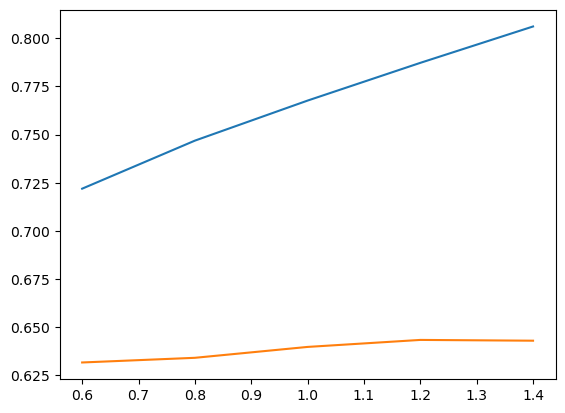

In [37]:
#finding C range
train_loss=[]
test_loss=[]
c_grid=[0.6,0.8,1,1.2,1.4]
for x in c_grid:
    clf=SVC(C=x)
    clf.fit(x_train,y_train)
    train_loss.append(clf.score(x_train,y_train))
    test_loss.append(clf.score(x_test,y_test))   
plt.plot(c_grid,train_loss)
plt.plot(c_grid,test_loss)
plt.show()  
    
    


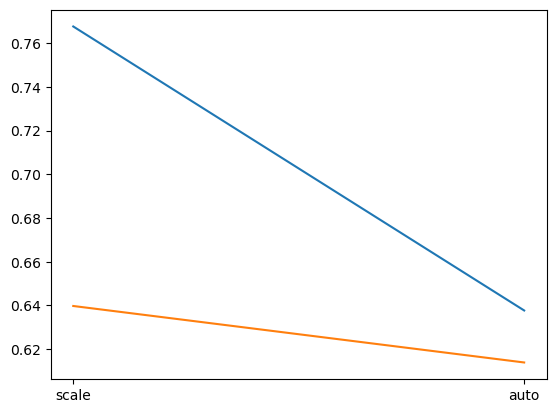

In [38]:
#checking gamma
train_loss=[]
test_loss=[]
gamma_grid=['scale','auto']
for x in gamma_grid:
    clf=SVC(gamma=x)
    clf.fit(x_train,y_train)
    train_loss.append(clf.score(x_train,y_train))
    test_loss.append(clf.score(x_test,y_test))   
plt.plot(gamma_grid,train_loss)
plt.plot(gamma_grid,test_loss)
plt.show() 
    
    


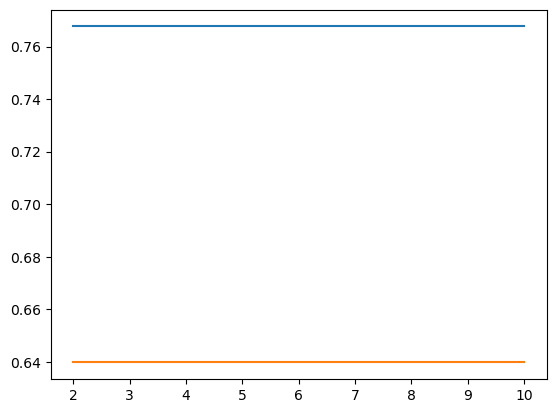

In [39]:
#finding degree range
train_loss=[]
test_loss=[]
degree_grid=[2,4,6,8,10]
for x in degree_grid:
    clf=SVC(degree=x)
    clf.fit(x_train,y_train)
    train_loss.append(clf.score(x_train,y_train))
    test_loss.append(clf.score(x_test,y_test))   
plt.plot(degree_grid,train_loss)
plt.plot(degree_grid,test_loss)
plt.show() 
    
    


In [40]:
'''n_comp_grid=[80,90,100,109]
c_grid=[0.9,1,1.1]

est=[('pca',PCA()),('svc',SVC())]
clf_pipe=Pipeline(steps=est)

param_dist={'pca__n_components':n_comp_grid,'svc__C':c_grid}


cross_val=RandomizedSearchCV(clf_pipe,param_distributions=param_dist,cv=cv,return_train_score=True,scoring='f1')
cross_val.fit(x_train,y_train)'''
    

"n_comp_grid=[80,90,100,109]\nc_grid=[0.9,1,1.1]\n\nest=[('pca',PCA()),('svc',SVC())]\nclf_pipe=Pipeline(steps=est)\n\nparam_dist={'pca__n_components':n_comp_grid,'svc__C':c_grid}\n\n\ncross_val=RandomizedSearchCV(clf_pipe,param_distributions=param_dist,cv=cv,return_train_score=True,scoring='f1')\ncross_val.fit(x_train,y_train)"

In [41]:
'''best_svc=cross_val.best_estimator_
best_svc'''

'best_svc=cross_val.best_estimator_\nbest_svc'

In [42]:
# best est = Pipeline(steps=[('pca', PCA(n_components=109)), ('svc', SVC(C=1))])

best_svc=Pipeline(steps=[('pca', PCA(n_components=109)), ('svc', SVC(C=1))])
best_svc.fit(x_train,y_train)
cls_report(best_svc)


              precision    recall  f1-score   support

           0       0.63      0.46      0.53      1077
           1       0.65      0.79      0.72      1399

    accuracy                           0.65      2476
   macro avg       0.64      0.62      0.62      2476
weighted avg       0.64      0.65      0.63      2476



In [43]:
best_svc.score(x_test,y_test)

0.6453957996768982

best_svc.score(x_test,y_test)

In [44]:
est=[('boosting',XGBClassifier())]
grad_pipe=Pipeline(steps=est)
grad_pipe.fit(x_train,y_train)
print(grad_pipe.score(x_test,y_test))
cls_report(grad_pipe)

0.6239903069466882
              precision    recall  f1-score   support

           0       0.58      0.49      0.53      1077
           1       0.65      0.73      0.69      1399

    accuracy                           0.62      2476
   macro avg       0.61      0.61      0.61      2476
weighted avg       0.62      0.62      0.62      2476



In [45]:
est=[('boosting',AdaBoostClassifier())]
grad_pipe=Pipeline(steps=est)
grad_pipe.fit(x_train,y_train)
print(grad_pipe.score(x_test,y_test))
cls_report(grad_pipe)

0.6106623586429726
              precision    recall  f1-score   support

           0       0.57      0.42      0.48      1077
           1       0.63      0.76      0.69      1399

    accuracy                           0.61      2476
   macro avg       0.60      0.59      0.59      2476
weighted avg       0.60      0.61      0.60      2476



Final 
* Taking svc as best estimator

In [46]:
results=best_svc.predict(preprocessor(test_data))


Processing test data


C:\Users\sanja\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [47]:
df_res=pd.DataFrame(data=range(test_data.shape[0]),columns=['id'])
df_res['Offer Accepted']=results
df_res['Offer Accepted'].replace({0:'No',1:'Yes'},inplace=True)
df_res

,id,Offer Accepted
0,0,Yes
1,1,Yes
2,2,No
3,3,No
4,4,Yes
...,...,...
5300,5300,Yes
5301,5301,Yes
5302,5302,No
5303,5303,Yes


In [48]:
df_res.to_csv("submission",index=False)